Data is [here](https://cycling.data.tfl.gov.uk)

Next steps:
- Find way to read in all csvs from website fast (Need to download from Amazon s3)
- Improve matplotlib plots

Ideas for future analysi:
- Look at how many people commute daily with bikes and what it depends on (e.g. weather, etc.)
- Look at same for non-commute rentals
- Look at paths bikes travel
- Look at most popular travel routes (maybe split by commuters and tourists)

In [34]:
import os
import glob
import janitor
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')

# # Save altair graph data locally to specified directory
# def json_dir(data, data_dir='altair_data'):
#     os.makedirs(data_dir, exist_ok=True)
#     return alt.pipe(data, alt.to_json(filename=data_dir + '/{prefix}-{hash}.{extension}') )
# alt.data_transformers.register('json_dir', json_dir)
# alt.data_transformers.enable('json_dir', data_dir='./data/altair_data')

# Prepare data

In [102]:
# Load sample data

files = glob.glob('./data/2016TripData/*.csv')
# files = glob.glob('./data/*2019.csv')
df = (
    pd.concat([pd.read_csv(f) for f in files], ignore_index=True, sort=False)
    .clean_names()
)

# Drop irrelevant columns
df.drop(list(df.filter(regex='unnamed|logical|priority')), axis = 1, inplace = True)

# Save working sample
df.sample(frac = 0.1).to_csv('./data/sample2016.csv', index=False)

In [103]:
# Read sample data

df = pd.read_csv('./data/sample2016.csv',
                 parse_dates=['start_date', 'end_date'],
                 infer_datetime_format=True)
df.head()

,rental_id,duration,bike_id,end_date,endstation_id,endstation_name,start_date,startstation_id,startstation_name
0,57156380,1500.0,9635.0,2016-08-13 14:24:00,786.0,"Lee Valley VeloPark, Queen Elizabeth Olympic Park",2016-08-13 13:59:00,786.0,"Lee Valley VeloPark, Queen Elizabeth Olympic Park"
1,56318113,1200.0,5214.0,2016-07-23 21:42:00,213.0,"Wellington Arch, Hyde Park",2016-07-23 21:22:00,266.0,"Queen's Gate (North), Kensington"
2,58564935,1020.0,7736.0,2016-09-20 09:04:00,335.0,"Tavistock Street, Covent Garden",2016-09-20 08:47:00,144.0,"Kennington Cross, Kennington"
3,54489035,480.0,2344.0,2016-06-03 17:13:00,520.0,"Bancroft Road, Bethnal Green",2016-06-03 17:05:00,520.0,"Bancroft Road, Bethnal Green"
4,52086848,3420.0,1181.0,2016-03-12 13:37:00,607.0,"Putney Bridge Station, Fulham",2016-03-12 12:40:00,688.0,"Northfields, Wandsworth"


# When do people rent cycles?

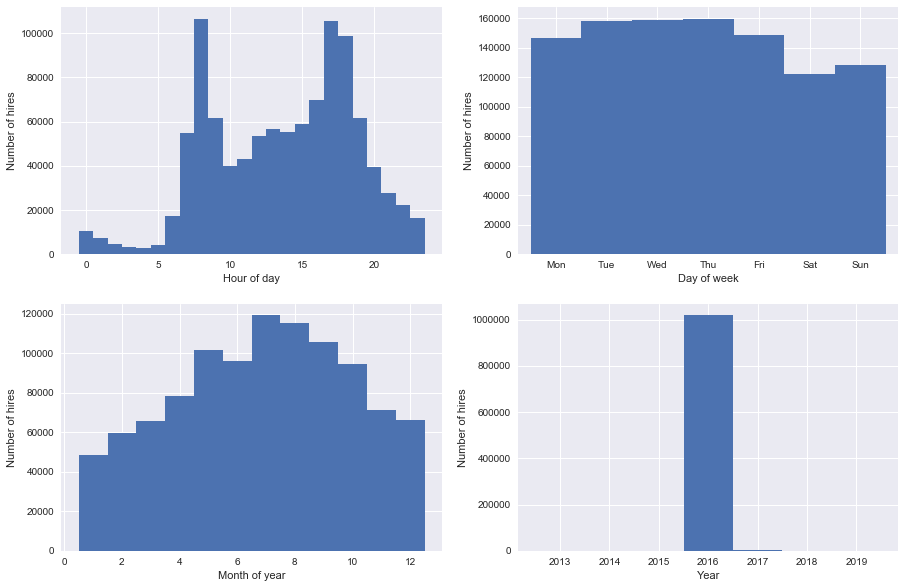

In [166]:
# Distributions of number of hires

plt.figure(figsize=(15,10))

# By hour of day
plt.subplot(221)
plt.hist(df['start_date'].dt.hour, bins=np.arange(0, 25)-0.5)
plt.xlabel('Hour of day')
plt.ylabel('Number of hires')

# By day of week
plt.subplot(222)
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df['dayofweek'] = df['start_date'].dt.weekday
grouped = df.groupby('dayofweek')['rental_id'].count()
grouped.index = days
grouped.plot(kind='bar', width=1)
plt.xticks(rotation=0)
plt.xlabel('Day of week')
plt.ylabel('Number of hires')

# By month of year
plt.subplot(223)
plt.hist(df['start_date'].dt.month, bins=np.arange(1,14)-0.5);
plt.xlabel('Month of year')
plt.ylabel('Number of hires')

# By year
plt.subplot(224)
plt.hist(df['start_date'].dt.year, bins=np.arange(2013,2021)-0.5)
plt.xlabel('Year')
plt.ylabel('Number of hires');

In [146]:
grouped = df.groupby('dayofweek')['rental_id'].count()
grouped.index = days
grouped

Mon    146258
Tue    158290
Wed    158536
Thu    159382
Fri    148479
Sat    122267
Sun    128427
Name: rental_id, dtype: int64

The patterns in hourly and dayly rentals suggest that quite a few people use bikes for their commute to work. Let's look into this further.

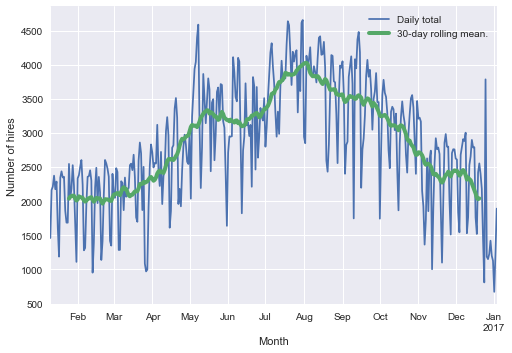

In [132]:
# Weekly rentals through the year

daily = df.set_index('start_date')['rental_id'].resample('d').count()
rolling = daily.rolling(30).mean(center=True)

daily.plot(label='Daily total')
rolling.plot(linewidth=4, label='30-day rolling mean.')
plt.xlabel('Month')
plt.ylabel('Number of hires')
plt.legend();

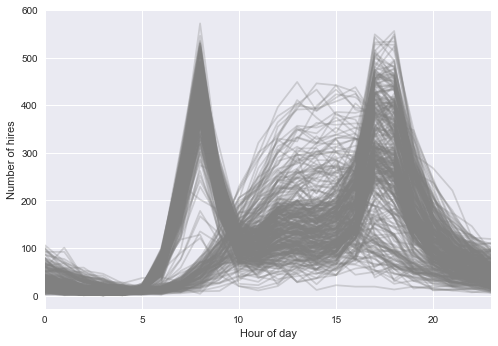

In [131]:
# Hourly rentals through the day

pivoted = df.pivot_table('rental_id',
               index=df['start_date'].dt.hour,
               columns=df['start_date'].dt.date,
               aggfunc='count'
              )

pivoted.plot(legend=None, color='grey', alpha=0.3)
plt.xlabel('Hour of day')
plt.ylabel('Number of hires');

# Learn more about commuting patterns

# Misc.

In [32]:
# Basic use of Beautiful soup from here: https://www.dataquest.io/blog/web-scraping-tutorial-python/

import requests
from bs4 import BeautifulSoup

url = 'https://cycling.data.tfl.gov.uk'

page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')
[type(item) for item in list(soup.children)]

html = list(soup.children)[0]
[type(item) for item in list(html.children)]

[bs4.element.NavigableString,
 bs4.element.Tag,
 bs4.element.NavigableString,
 bs4.element.Tag,
 bs4.element.NavigableString]